# Lab 16: Decision tree and random forest classifiers

Decision trees can also be used for classification, or predicting the category a piece of data falls in.  

We will first look at using decision trees to predict the location of vegetation on satellite images.

Sections 1-3 of this lab are adapted from IACA Data Science Winter Pedagogy Workshop by Weiwei Pan and David Sondak (the [Day 3: Classification - decision trees, random forests and k-NN classifiers notebook](https://deepnote.com/project/3-more-classification-qkzrkkMjSYW8BqqN9u5Fyg/%2F05_classification_trees_and_forests.ipynb))

Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Section 1: Monitoring changes in land cover using satellite images

Satellite images can be used to detect changes in land cover. For example, the images below show how the vegetation cover around Belize and Guatemala changed from 1975 to 2007:

<img src="http://www.terra-i.org/magnoliaAuthor/dam/jcr:b0a9f05a-e8a3-457b-9df2-eb10d921c69d/33_border_guatemala_1975_2007_full.jpg">

We will look at labelled data that has been generated by hand.  The first two columns contain normalized (scaled to have a mean of 0 and variance of 1) latitude and longitude values.  The third column indicates whether that locaiton contains vegetation, with 1 for vegetation and a 0 if not.  We want to use this data to predict whether a new location will contain vegetation.

Data URL: https://raw.githubusercontent.com/onefishy/rwanda_2019/master/dataset_2.txt

Open the data in Jupyter notebook.  What do you notice about the file?

While the columns are separated by commas, there are no column headers.  The first two columns are the normalized location coordinates, and the third column is a 0 if there is no vegetation at that location and a 1 if there is vegetation at that location.

Can you figure out how to read in the data, giving the columns the names `x_coord`, `y_coord`, and `veg`?  Hint:  See Lab 14.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/onefishy/rwanda_2019/master/dataset_2.txt", \
                 header = None, names = ["x_coord", "y_coord", "veg"])
df.head()

,x_coord,y_coord,veg
0,0.266809,0.688130,1.0
1,0.100046,0.520933,1.0
2,0.158702,0.436935,1.0
3,0.174504,0.538224,1.0
4,0.258707,0.615527,1.0


<details><summary>Answer:</summary>
<code>
df = pd.read_csv("https://raw.githubusercontent.com/onefishy/rwanda_2019/master/dataset_2.txt", header = None, names = ["x_coord", "y_coord", "veg"])
</code>
</details>

Plot the data as a scatterplot (with `x_coord` on the x axis and `y_coord` on the y axis) colored by the `veg` column.  If you are using Seaborn `relplot()`, you can color the vegetation green and the lack of vegetation brown with the parameter `palette = ["brown","green"]`.

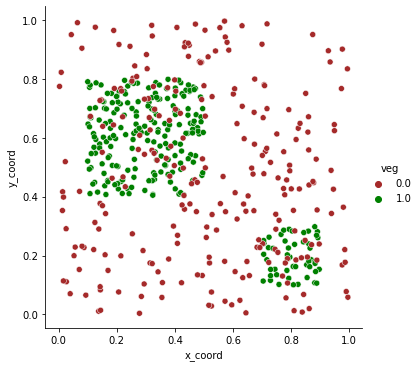

In [6]:
sns.relplot(x = "x_coord", y = "y_coord", hue = "veg", palette = ["brown", "green"], data = df)

What do you notice about the location and shape of the vegetation?

We will also use the scikit learn package for decision tree classifiers, so we need to prepare the data in the same way:
* create a variable `x` containing the first two columns, which will be used to train the model and make the predictions
* create a variable `y` containing the third column, which is the variable we are trying to predict

In [7]:
x = df[["x_coord", "y_coord"]]
y = df["veg"]

In [8]:
x.head()

,x_coord,y_coord
0,0.266809,0.688130
1,0.100046,0.520933
2,0.158702,0.436935
3,0.174504,0.538224
4,0.258707,0.615527


In [9]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: veg, dtype: float64

Finally, split the data into training (80%) and testing (20%) data.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [11]:
x_train

,x_coord,y_coord
397,0.268650,0.808278
259,0.570716,0.996753
449,0.889131,0.354953
8,0.266922,0.623476
393,0.857484,0.619587
...,...,...
45,0.145898,0.779796
168,0.229745,0.749169
487,0.253582,0.273810
36,0.155711,0.722957


### Section 2: Decision tree classifiers

We will fit a decision tree classifier to the training data with the following code:

In [12]:
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5)

Can you figure out how to use this model to predict whether there is a vegetation at each coordinate in the test data?  

Hint:  All scikit-learn machine learning models use the same code functions.

In [15]:
y_test_preds = tree.predict(x_test)

<details><summary>Answer:</summary>
y_test_preds = tree.predict(x_test)
</details>

We can also generate a confusion matrix to evaluate the classification with scikit-learn:

In [16]:
confusion_matrix(y_test,y_test_preds)

array([[40, 17],
       [ 1, 42]])

As long as the true values are the first parameter and the predictions are the second parameter, the confusion matrix will have the same format as the one generated by `statsmodels`:

<code>   
                        predicted
             |    0           |      1      |
             --------------------------------
observed | 0 | true negative  | false positive
         | 1 | false negative | true positive
</code>

If the categories are something other than 0 and 1, they will be ordered in alphabetically order (ie. the first row is the category closest to a in the alphabet).

Which does our decision tree predict the location of better:  vegetation or no vegetation?

### Section 3: Understanding decision trees through visualization

Let's visualize the predictions being made by the decision tree.

The following function will plot a scatter plot of the data overlaided with the *decision tree boundary*, which shows what each coordinate will be predicted as.  You do not have to understand the details of the function (it uses MatPlotLib functions that we have not learned yet).

Run this code to load the functions into the notebook so we can use them.

In [17]:
def scatter_plot_data(x_df, y_series, ax):
    '''
    scatter_plot_data scatter plots the satellite data. A point in the plot is colored 'green' if 
    vegetation is present and 'gray' otherwise.
    
    input:
       x_df - a DataFrame of size N x 2, each row is a location, each column is a coordinate
       y_series - a Series of length N, each entry is either 0 (no vegetation) or 1 (vegetation)
       ax - axis to plot on
    returns: 
       ax - the axis with the scatter plot
    '''
    
    # convert x_df and y_series into numpy arrays
    x = x_df.values
    y = y_series.values
    
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='green', label='vegetation')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='gray', label='nonvegetation')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.legend(loc='best')
    return ax

def plot_decision_boundary(x_df, y_series, model, ax, plot_boundary_only=False):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x_df - a DataFrame of size N x 2, each row is a location, each column is a coordinate
       y_series - a Series of length N, each entry is either 0 (non-vegetation) or 1 (vegetation)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    
    # convert x_df and y_series into numpy arrays
    x = x_df.values
    y = y_series.values
    
    # Plot data
    if not plot_boundary_only:
        ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='green', label='vegetation')
        ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='gray', label='non-vegetation')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)
    
    # Predict on mesh points
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if not plot_boundary_only:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    ax.contour(x1, x2, yy, colors='black', linewidths=0.1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.legend(loc='best')
    return ax

First, let's use this code to plot the decision tree boundary of the decision tree we just fitted.

Text(0.5, 1.0, 'Decision Boundary on the Test Data')

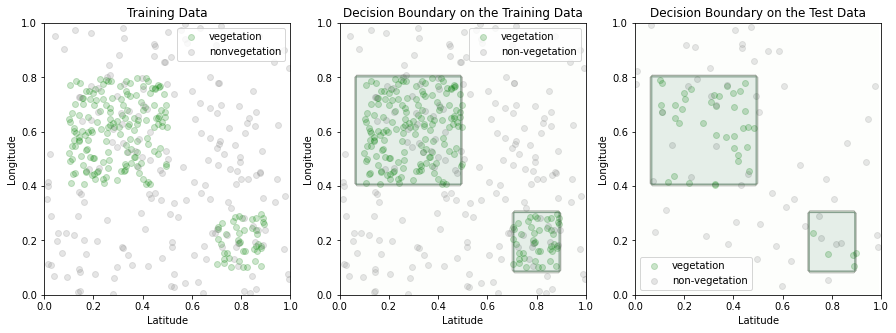

In [18]:
# set up to create two plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_train, y_train, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_train, y_train, tree, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')

#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, tree, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

Any coordinates in the shaded green area will be predicted as vegetation, while all other coordinates will be predicted as non-vegetation.

How well does this decision tree work?  Are there locations where it is not working well?  Does the visualization of the decision tree boundary on the test data match what we saw in the confusion matrix?

To better understand how decision trees work, let's visualize the boundaries of trees with different max depths.

Note:  We will re-divide the data in training and testing data in a way that is not random (using the parameter `random_state = 7`), so that everyone will get the same results in this section.

First we look at a max depth of 1.  


Text(0.5, 1.0, 'Decision Boundary on the Test Data')

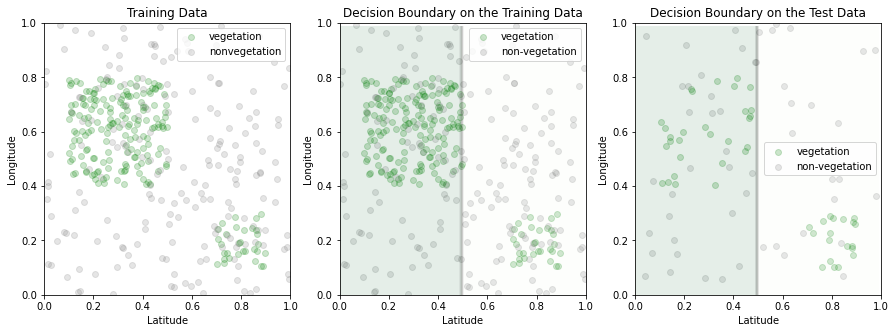

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 7)

tree1 = DecisionTreeClassifier(max_depth = 1)
tree1.fit(x_train,y_train)

# set up to create three plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_train, y_train, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_train, y_train, tree1, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')


#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, tree1, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

How many boundary lines are used to make this decision boundary?

Run the following code only if you used plot_tree() without an error in Lab 12.

[Text(167.4, 163.07999999999998, 'x_coord <= 0.499\ngini = 0.5\nsamples = 400\nvalue = [198, 202]'),
 Text(83.7, 54.360000000000014, 'gini = 0.452\nsamples = 261\nvalue = [90, 171]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.347\nsamples = 139\nvalue = [108, 31]')]

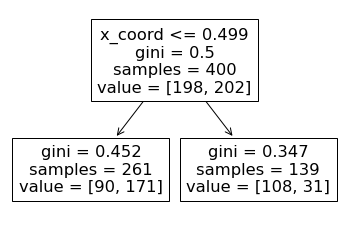

In [20]:
# only run this code if you used plot_tree() without an error in Lab 12

from sklearn.tree import plot_tree

plot_tree(tree1, feature_names = x.columns)

Alternatively, the decision tree is

<img src="https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/images/Lab%2016%20decision_tree_depth_1.png">

The first node check if the x coordinate is less than 0.499.  Notice that this corresponds to the vertical decision boundary in the plot above.  If the x coordinate is less than 0.499, we follow the left branch and otherwise we follow the right branch.

When the decision tree is a classifier, the last line in each node (box) tells us how many data points belong to each category.  The order of the categories is alphabetical, so in the top node, 198 of the data points are 0 and 202 of the data points are 1.  The predicted category for that node is the largest category (so 1 for the top node).

Of the data points that fall into the bottom left node (because their x coordinate is less than or equal to 0.499), 90 are category 0 and 171 are category 1.  Thus this node predicts category 1 (vegetation), which is reflected in the green shading to the left of x coordinate 0.499 in the decision tree boundary above.

Of the data points that fall into the bottom right node (because their x coordinate is greater than 0.499), 108 are in category 0 and 31 are in category 1.  Thus any new data point reaching this node is predicted as 0 (non-vegetation), which is reflected in points to the right of the x coordinate 0.499 not being shaded green in the decision tree boundary plot above.

We now repeat this process with a tree of max depth 2.



Text(0.5, 1.0, 'Decision Boundary on the Test Data')

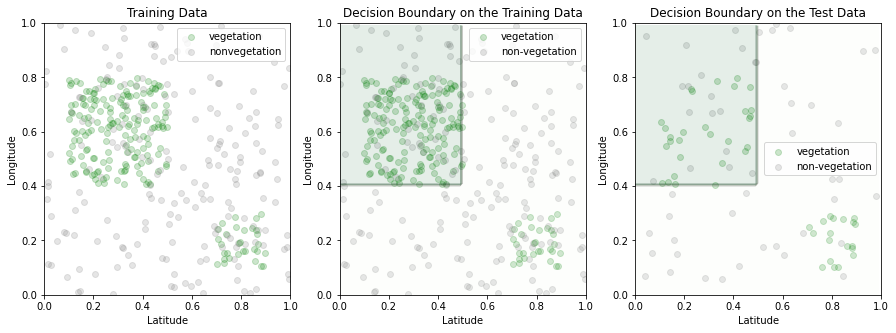

In [21]:
tree2 = DecisionTreeClassifier(max_depth = 2)
tree2.fit(x_train,y_train)

# set up to create three plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_train, y_train, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_train, y_train, tree2, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')


#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, tree2, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

How did the decision boundary change?

If convenient, plot the decision tree or check out the image below.

[Text(290.625, 471.875, 'x_coord <= 0.499\ngini = 0.5\nsamples = 400\nvalue = [198, 202]'),
 Text(145.3125, 283.125, 'y_coord <= 0.405\ngini = 0.452\nsamples = 261\nvalue = [90, 171]'),
 Text(72.65625, 94.375, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(217.96875, 94.375, 'gini = 0.368\nsamples = 226\nvalue = [55, 171]'),
 Text(435.9375, 283.125, 'y_coord <= 0.309\ngini = 0.347\nsamples = 139\nvalue = [108, 31]'),
 Text(363.28125, 94.375, 'gini = 0.49\nsamples = 72\nvalue = [41, 31]'),
 Text(508.59375, 94.375, 'gini = 0.0\nsamples = 67\nvalue = [67, 0]')]

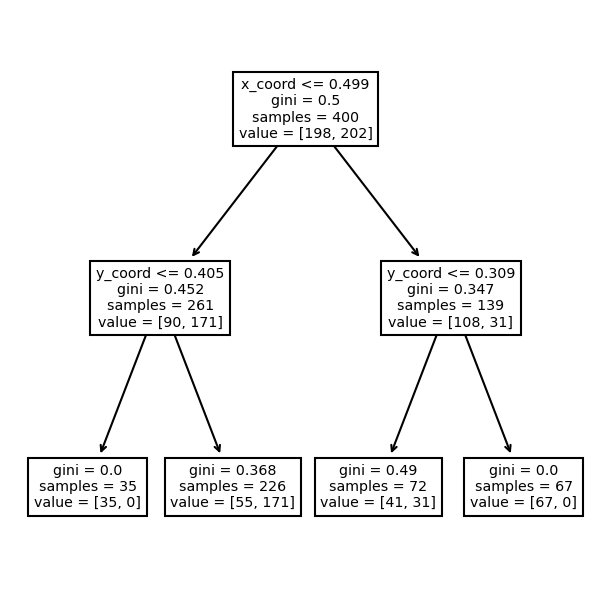

In [22]:
# only run this code if you used plot_tree() without an error in Lab 12

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=150)
plot_tree(tree2, feature_names = x.columns)

Alternatively, the decision tree is

<img src="https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/images/Lab%2016%20decision_tree_depth_2.png">

The top node (box) is the same as the max depth 1 tree, and the values in the second (middle) level nodes are the same.  However, the second level nodes now each have a (different) condition on the y coordinate.  

These y-coordinates conditions divide the two areas from the max depth 1 tree decision boundary in two again, to give four areas.  However, only one of these four areas is predicted to have vegetation.   This corresponds to only one of the bottom nodes having a higher number in the second position for `value` (the node with `value = [55,171]`).

Finally, let's create and plot the boundary of a max depth 3 decision tree.

Text(0.5, 1.0, 'Decision Boundary on the Test Data')

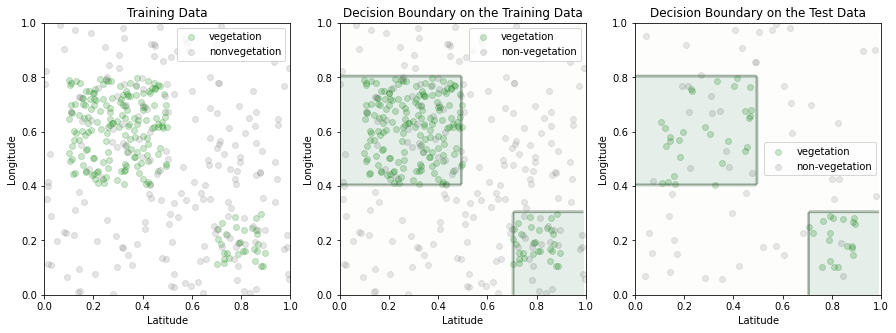

In [23]:
tree3 = DecisionTreeClassifier(max_depth = 3)
tree3.fit(x_train,y_train)

# set up to create three plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_train, y_train, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_train, y_train, tree3, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')


#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, tree3, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

How did the decision boundary change?

If possible, plot the decision tree or check out the image below.

[Text(290.625, 495.46875, 'x_coord <= 0.499\ngini = 0.5\nsamples = 400\nvalue = [198, 202]'),
 Text(116.25, 353.90625, 'y_coord <= 0.405\ngini = 0.452\nsamples = 261\nvalue = [90, 171]'),
 Text(58.125, 212.34375, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(174.375, 212.34375, 'y_coord <= 0.801\ngini = 0.368\nsamples = 226\nvalue = [55, 171]'),
 Text(116.25, 70.78125, 'gini = 0.292\nsamples = 208\nvalue = [37, 171]'),
 Text(232.5, 70.78125, 'gini = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(465.0, 353.90625, 'y_coord <= 0.309\ngini = 0.347\nsamples = 139\nvalue = [108, 31]'),
 Text(406.875, 212.34375, 'x_coord <= 0.703\ngini = 0.49\nsamples = 72\nvalue = [41, 31]'),
 Text(348.75, 70.78125, 'gini = 0.0\nsamples = 17\nvalue = [17, 0]'),
 Text(465.0, 70.78125, 'gini = 0.492\nsamples = 55\nvalue = [24, 31]'),
 Text(523.125, 212.34375, 'gini = 0.0\nsamples = 67\nvalue = [67, 0]')]

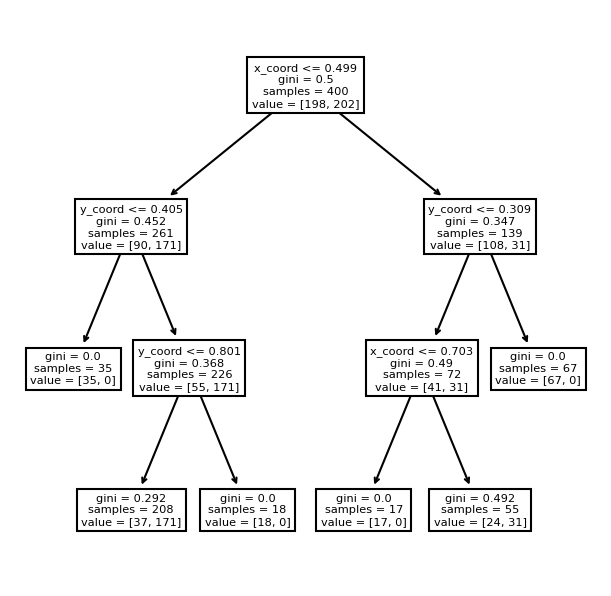

In [24]:
# only run this code if you used plot_tree() without an error in Lab 12
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=150)
plot_tree(tree3, feature_names = x.columns)

Alternatively, the decision tree is

<img src="https://raw.githubusercontent.com/megan-owen/MAT328-Techniques_in_Data_Science/main/images/Lab%2016%20decision_tree_depth_3.png">

In this decision tree, the top two levels are the same as the max depth 2 decision tree, and the values in the third level are the same for the four nodes.  

The first and last nodes in the third level down only have non-vegetation data points (because the second `value` is 0), so the tree ends at these nodes.

Can you figure out which lines in decision boundary the two other nodes in the third level correspond to?

### Section 4: Random forests

A *random forest* is the machine learning version of crowd-sourcing or "ask the audience" in a game show like "Who wants to be a millionaire?".  A random forest works by taking a bunch of different random samples of the training data and constructing the decision tree for each random sample.  To make a prediction, each of these decision trees makes its prediction and whatever is predicted by the majority of the decision trees is the prediction of the random forest.

One of the advantages of the random forest is overfitting errors in the decision trees can be canceled out.

For example, the following code takes a random sample of the training data, finds the decision tree of max depth 100 on it, and displays the decision boundary.

Text(0.5, 1.0, 'Decision Boundary on the Test Data')

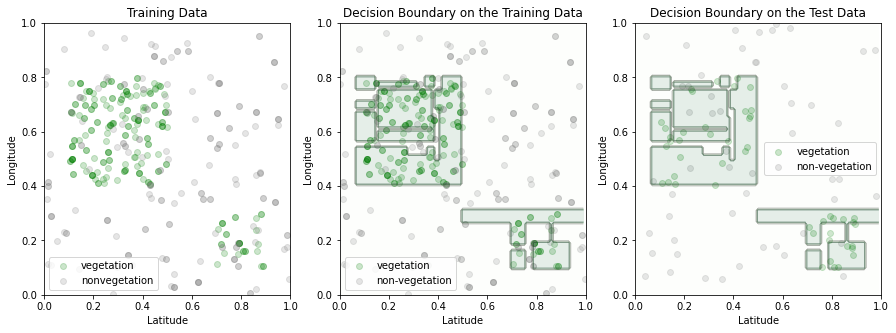

In [25]:
# take a random sample with replacement
indices = np.arange(x_train.shape[0])
sampled_indices = np.random.choice(indices, x_train.shape[0])
x_sample = x_train.iloc[sampled_indices]
y_sample = y_train.iloc[sampled_indices]

tree100 = DecisionTreeClassifier(max_depth = 100)
tree100.fit(x_sample,y_sample)

# set up to create three plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_sample, y_sample, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_sample, y_sample, tree100, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')


#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, tree100, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

Rerun the above code several times.  How does the decision boundary change?  What evidence of overfitting do you see in the decision boundary?

Use the last decision tree made to make predictions for the test data.

In [26]:
y_test_pred100 = tree100.predict(x_test)

What is the confusion matrix for these predictions?

In [27]:
confusion_matrix(y_test, y_test_pred100)

array([[40, 12],
       [10, 38]])

Based on the confusion matrices, how does this decision tree compare to the one we computed in Section 2?  Which decision tree is better?

Now, let's fit a random forest with 500 decision trees, each of max depth 100, to the training data.

In [28]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 100)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=500)

Can you figure out how to make predictions on the test data with the random forest classifier, and then compute the confusion matrix?  Remember all scikit-learn classifiers use the same functions.

In [29]:
y_test_pred_rf = rf.predict(x_test)

In [30]:
confusion_matrix(y_test,y_test_pred_rf)

array([[41, 11],
       [13, 35]])

<details><summary>Answer:</summary>
<code>
y_test_preds_rf = rf.predict(x_test)
confusion_matrix(y_test,y_test_preds_rf)
</code>
</details>

Which model is better?  The random forest of 500 depth 100 decision trees, or a single depth 100 decision tree?

How does the random forest compare to our decision tree in section 2?

Finally, run the code below to see a plot of the decision boundary for the random forest.

Text(0.5, 1.0, 'Decision Boundary on the Test Data')

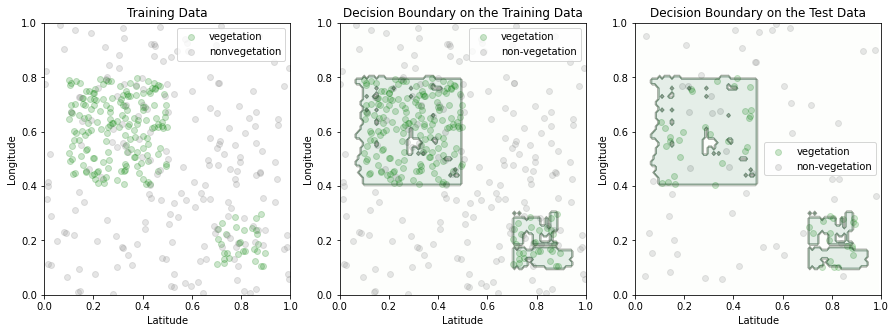

In [31]:
# set up to create three plots in the same image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# visualize the data on the first plot (ax[0])
scatter_plot_data(x_train, y_train, ax[0])
ax[0].set_title('Training Data')

#  plot the training data and decision tree boundary on the second plot (ax[1])
plot_decision_boundary(x_train, y_train, rf, ax[1])
ax[1].set_title('Decision Boundary on the Training Data')


#  plot the test data and decision tree boundary on the third plot (ax[2])
plot_decision_boundary(x_test, y_test, rf, ax[2])
ax[2].set_title('Decision Boundary on the Test Data')

What do you notice about the decision boundary of the random forest? 
